In [1]:
import torch
torch.__version__

'2.5.1+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
import os
from tqdm import tqdm
from sklearn.metrics import f1_score

## Load Data

In [4]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ekstrak label dan piksel
        self.labels = self.dataframe['emotion'].values
        self.pixels = self.dataframe['pixels'].apply(self.string_to_image).values

    def string_to_image(self, pixels_string):
        # Konversi string piksel menjadi numpy array dan reshape ke 48x48
        pixels = np.array(pixels_string.split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = np.expand_dims(image, axis=-1)  # Tambahkan channel dimensi
        return image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image.squeeze().astype('uint8'), mode='L')

        # Jika ada transformasi, terapkan ke image
        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])           
print(f"transforms: {manual_transforms}")

transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)


In [6]:
data = pd.read_csv('../Data/fer2013_clean.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33325 entries, 0 to 33324
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pixels   33325 non-null  object
 1   emotion  33325 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 520.8+ KB


In [7]:
# Pertama, pisahkan data train (90%) dan validation (10%)
data_train, data_test = train_test_split(data, test_size=0.1, stratify=data['emotion'], random_state=123)
data_train, data_val = train_test_split(data_train, test_size=0.1, stratify=data_train['emotion'], random_state=123)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

Train set size: 26992
Validation set size: 3000
Test set size: 3333


In [8]:
train_dataset = FERDataset(data_train, transform=manual_transforms)
val_dataset = FERDataset(data_val, transform=manual_transforms)
test_dataset = FERDataset(data_test, transform=manual_transforms)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [9]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Mapping dari label ke ID (label2id)
label2id = {c: idx for idx, c in enumerate(labels)}

# Mapping dari ID ke label (id2label)
id2label = {idx: c for idx, c in enumerate(labels)}

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6}
id2label: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


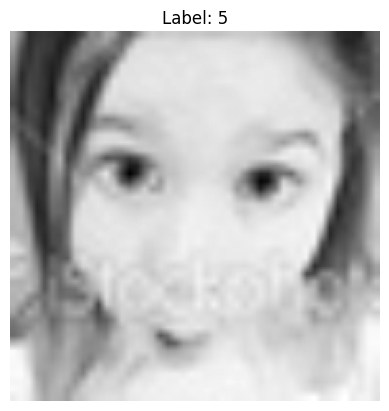

In [10]:
# Ambil satu contoh dari train_dataset
image, label = train_dataset[0]  # Index pertama dataset

# Jika transform menghasilkan tensor, konversi ke format numpy
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# Plot gambar
plt.imshow(image, cmap='gray')  # Gunakan cmap='gray' jika gambar grayscale
plt.title(f"Label: {label}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

In [11]:
image, label = train_dataset[0]
image.shape

torch.Size([1, 224, 224])

## Build Vision Transformer (ViT) Model

In [12]:
from torch import nn

In [13]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=768
                ):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
    def forward(self, x):
        image_resolution = x.shape[-1]
        
        x_patched = self.patcher(x) # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x_flattened = x_patched.flatten(2) # (n_samples, embed_dim, n_patches)
        x = x_flattened.transpose(1, 2) # (n_samples, n_patches, embed_dim)
        
        return x

In [14]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [15]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

In [16]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(self.layer_norm1(x)) + x 
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x

In [17]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0.,
                 mlp_dropout:float=0.,
                 embedding_dropout:float=0.,
                 num_classes:int=1000):
        super().__init__()
        self.num_patches = (img_size * img_size) // patch_size**2

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    def forward(self, pixel_values, labels=None):
        batch_size = pixel_values.shape[0]

        x = self.patch_embedding(pixel_values) # (n_samples, num_patches, embed_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) # (n_samples, 1, embed_dim)

        x = torch.cat((class_token, x), dim=1) # (n_samples, 1 + n_patches, embed_dim)

        x = self.position_embedding + x # add position embed

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        logits = self.classifier(x[:, 0])

        # Jika labels diberikan, hitung loss
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
    
        return (loss, logits) if loss is not None else logits

## Model Training

In [18]:
model = ViT(num_classes=len(class_names), in_channels=1, patch_size=32, num_heads=8, embedding_dim=512, num_transformer_layers=12)

In [19]:
from torchinfo import summary

summary(
    model=model,
    input_size=(1, 1, 224, 224),  # (batch_size, in_channels, img_size, img_size)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=15,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
ViT (ViT)                                                    [1, 1, 224, 224] [1, 7]          26,112          True
├─PatchEmbedding (patch_embedding)                           [1, 1, 224, 224] [1, 49, 512]    --              True
│    └─Conv2d (patcher)                                      [1, 1, 224, 224] [1, 512, 7, 7]  524,800         True
├─Dropout (embedding_dropout)                                [1, 50, 512]    [1, 50, 512]    --              --
├─Sequential (transformer_encoder)                           [1, 50, 512]    [1, 50, 512]    --              True
│    └─TransformerEncoderBlock (0)                           [1, 50, 512]    [1, 50, 512]    --              True
│    │    └─LayerNorm (layer_norm1)                          [1, 50, 512]    [1, 50, 512]    1,024           True
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [1, 50, 512]    [1, 5

In [20]:
EPOCHS = 1000
LEARNING_RATE = 3e-5
NUM_CLASSES = 7
SEED = 123
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Define path
SAVE_PATH = "../Hasil Eksperimen"
os.makedirs(SAVE_PATH, exist_ok=True)

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize the best metric for model saving
best_val_accuracy = -float('inf')

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    # Training
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Update progress bar
        pbar.set_postfix({
            "Loss": f"{train_loss / (batch_idx + 1):.4f}",
            "Acc": f"{correct / total:.4f}"
        })

    # Calculate training accuracy and loss
    train_accuracy = correct / total
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Print training summary
    print(f"Epoch {epoch + 1}/{EPOCHS}: "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_targets = []
    all_predicted = []

    with torch.no_grad():  # Disable gradient computation
        pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} (Validation)")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Update statistics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

            # Collect all targets and predictions for F1-score
            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({
                "Loss": f"{val_loss / (batch_idx + 1):.4f}",
                "Acc": f"{val_correct / val_total:.4f}"
            })

    # Calculate validation accuracy, loss, and F1-score
    val_accuracy = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(all_targets, all_predicted, average="weighted")
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print validation summary
    print(f"Epoch {epoch + 1}/{EPOCHS}: "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_accuracy:.4f}, "
          f"Val F1: {val_f1:.4f}")

    # Step the learning rate scheduler based on validation loss
    scheduler.step(avg_val_loss)

    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr}")

    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model_path = os.path.join(SAVE_PATH, "model7_best.pt")
        torch.save(model.state_dict(), model_path)
        print(f"Best model saved at {model_path} with val accuracy: {best_val_accuracy:.4f}")

    # Save loss and accuracy plots
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    loss_plot_path = os.path.join(SAVE_PATH, "model7_loss.png")
    plt.savefig(loss_plot_path)
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy", marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker='o')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    accuracy_plot_path = os.path.join(SAVE_PATH, "model7_acc.png")
    plt.savefig(accuracy_plot_path)
    plt.close()

Epoch 1/1000: 100%|██████████| 422/422 [02:06<00:00,  3.33it/s, Loss=1.7560, Acc=0.2756]


Epoch 1/1000: Train Loss: 1.7560, Train Acc: 0.2756


Epoch 1/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.27it/s, Loss=1.6909, Acc=0.3387]


Epoch 1/1000: Val Loss: 1.6909, Val Acc: 0.3387, Val F1: 0.3003
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/model7_best.pt with val accuracy: 0.3387


Epoch 2/1000: 100%|██████████| 422/422 [02:11<00:00,  3.21it/s, Loss=1.6128, Acc=0.3697]


Epoch 2/1000: Train Loss: 1.6128, Train Acc: 0.3697


Epoch 2/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.70it/s, Loss=1.6102, Acc=0.3747]


Epoch 2/1000: Val Loss: 1.6102, Val Acc: 0.3747, Val F1: 0.3004
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/model7_best.pt with val accuracy: 0.3747


Epoch 3/1000: 100%|██████████| 422/422 [02:13<00:00,  3.17it/s, Loss=1.5480, Acc=0.3953]


Epoch 3/1000: Train Loss: 1.5480, Train Acc: 0.3953


Epoch 3/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  8.37it/s, Loss=1.5294, Acc=0.4143]


Epoch 3/1000: Val Loss: 1.5294, Val Acc: 0.4143, Val F1: 0.3825
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/model7_best.pt with val accuracy: 0.4143


Epoch 4/1000: 100%|██████████| 422/422 [02:13<00:00,  3.16it/s, Loss=1.4947, Acc=0.4198]


Epoch 4/1000: Train Loss: 1.4947, Train Acc: 0.4198


Epoch 4/1000 (Validation): 100%|██████████| 47/47 [00:08<00:00,  5.67it/s, Loss=1.5257, Acc=0.4070]


Epoch 4/1000: Val Loss: 1.5257, Val Acc: 0.4070, Val F1: 0.3756
Current Learning Rate: 3e-05


Epoch 5/1000: 100%|██████████| 422/422 [02:05<00:00,  3.37it/s, Loss=1.4487, Acc=0.4406]


Epoch 5/1000: Train Loss: 1.4487, Train Acc: 0.4406


Epoch 5/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  5.18it/s, Loss=1.5005, Acc=0.4263]


Epoch 5/1000: Val Loss: 1.5005, Val Acc: 0.4263, Val F1: 0.4011
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/model7_best.pt with val accuracy: 0.4263


Epoch 6/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=1.4015, Acc=0.4573]


Epoch 6/1000: Train Loss: 1.4015, Train Acc: 0.4573


Epoch 6/1000 (Validation): 100%|██████████| 47/47 [00:11<00:00,  4.25it/s, Loss=1.4908, Acc=0.4233]


Epoch 6/1000: Val Loss: 1.4908, Val Acc: 0.4233, Val F1: 0.3946
Current Learning Rate: 3e-05


Epoch 7/1000: 100%|██████████| 422/422 [02:12<00:00,  3.19it/s, Loss=1.3505, Acc=0.4795]


Epoch 7/1000: Train Loss: 1.3505, Train Acc: 0.4795


Epoch 7/1000 (Validation): 100%|██████████| 47/47 [00:10<00:00,  4.49it/s, Loss=1.4685, Acc=0.4427]


Epoch 7/1000: Val Loss: 1.4685, Val Acc: 0.4427, Val F1: 0.4324
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/model7_best.pt with val accuracy: 0.4427


Epoch 8/1000: 100%|██████████| 422/422 [02:06<00:00,  3.33it/s, Loss=1.2838, Acc=0.5062]


Epoch 8/1000: Train Loss: 1.2838, Train Acc: 0.5062


Epoch 8/1000 (Validation): 100%|██████████| 47/47 [00:04<00:00, 10.29it/s, Loss=1.4610, Acc=0.4463]


Epoch 8/1000: Val Loss: 1.4610, Val Acc: 0.4463, Val F1: 0.4407
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/model7_best.pt with val accuracy: 0.4463


Epoch 9/1000: 100%|██████████| 422/422 [02:05<00:00,  3.36it/s, Loss=1.2037, Acc=0.5399]


Epoch 9/1000: Train Loss: 1.2037, Train Acc: 0.5399


Epoch 9/1000 (Validation): 100%|██████████| 47/47 [00:04<00:00, 10.24it/s, Loss=1.4590, Acc=0.4600]


Epoch 9/1000: Val Loss: 1.4590, Val Acc: 0.4600, Val F1: 0.4473
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/model7_best.pt with val accuracy: 0.4600


Epoch 10/1000: 100%|██████████| 422/422 [02:11<00:00,  3.20it/s, Loss=1.0969, Acc=0.5833]


Epoch 10/1000: Train Loss: 1.0969, Train Acc: 0.5833


Epoch 10/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  8.13it/s, Loss=1.5416, Acc=0.4513]


Epoch 10/1000: Val Loss: 1.5416, Val Acc: 0.4513, Val F1: 0.4358
Current Learning Rate: 3e-05


Epoch 11/1000: 100%|██████████| 422/422 [02:04<00:00,  3.40it/s, Loss=0.9542, Acc=0.6439]


Epoch 11/1000: Train Loss: 0.9542, Train Acc: 0.6439


Epoch 11/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=1.6283, Acc=0.4497]


Epoch 11/1000: Val Loss: 1.6283, Val Acc: 0.4497, Val F1: 0.4487
Current Learning Rate: 3e-05


Epoch 12/1000: 100%|██████████| 422/422 [02:10<00:00,  3.23it/s, Loss=0.7801, Acc=0.7068]


Epoch 12/1000: Train Loss: 0.7801, Train Acc: 0.7068


Epoch 12/1000 (Validation): 100%|██████████| 47/47 [00:10<00:00,  4.51it/s, Loss=1.7567, Acc=0.4550]


Epoch 12/1000: Val Loss: 1.7567, Val Acc: 0.4550, Val F1: 0.4463
Current Learning Rate: 3e-05


Epoch 13/1000: 100%|██████████| 422/422 [02:23<00:00,  2.95it/s, Loss=0.5800, Acc=0.7870]


Epoch 13/1000: Train Loss: 0.5800, Train Acc: 0.7870


Epoch 13/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=1.9078, Acc=0.4490]


Epoch 13/1000: Val Loss: 1.9078, Val Acc: 0.4490, Val F1: 0.4452
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|██████████| 422/422 [02:18<00:00,  3.05it/s, Loss=0.3937, Acc=0.8612]


Epoch 14/1000: Train Loss: 0.3937, Train Acc: 0.8612


Epoch 14/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  8.05it/s, Loss=2.2660, Acc=0.4490]


Epoch 14/1000: Val Loss: 2.2660, Val Acc: 0.4490, Val F1: 0.4435
Current Learning Rate: 3e-05


Epoch 15/1000: 100%|██████████| 422/422 [02:11<00:00,  3.20it/s, Loss=0.2514, Acc=0.9139]


Epoch 15/1000: Train Loss: 0.2514, Train Acc: 0.9139


Epoch 15/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  7.92it/s, Loss=2.5950, Acc=0.4470]


Epoch 15/1000: Val Loss: 2.5950, Val Acc: 0.4470, Val F1: 0.4439
Current Learning Rate: 3e-06


Epoch 16/1000: 100%|██████████| 422/422 [02:21<00:00,  2.99it/s, Loss=0.0783, Acc=0.9802]


Epoch 16/1000: Train Loss: 0.0783, Train Acc: 0.9802


Epoch 16/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.06it/s, Loss=2.6965, Acc=0.4637]


Epoch 16/1000: Val Loss: 2.6965, Val Acc: 0.4637, Val F1: 0.4608
Current Learning Rate: 3e-06
Best model saved at ../Hasil Eksperimen/model7_best.pt with val accuracy: 0.4637


Epoch 17/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=0.0357, Acc=0.9953]


Epoch 17/1000: Train Loss: 0.0357, Train Acc: 0.9953


Epoch 17/1000 (Validation): 100%|██████████| 47/47 [00:13<00:00,  3.41it/s, Loss=2.8110, Acc=0.4627]


Epoch 17/1000: Val Loss: 2.8110, Val Acc: 0.4627, Val F1: 0.4604
Current Learning Rate: 3e-06


Epoch 18/1000: 100%|██████████| 422/422 [02:12<00:00,  3.19it/s, Loss=0.0237, Acc=0.9973]


Epoch 18/1000: Train Loss: 0.0237, Train Acc: 0.9973


Epoch 18/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  8.56it/s, Loss=2.9108, Acc=0.4650]


Epoch 18/1000: Val Loss: 2.9108, Val Acc: 0.4650, Val F1: 0.4628
Current Learning Rate: 3e-06
Best model saved at ../Hasil Eksperimen/model7_best.pt with val accuracy: 0.4650


Epoch 19/1000: 100%|██████████| 422/422 [02:11<00:00,  3.21it/s, Loss=0.0174, Acc=0.9981]


Epoch 19/1000: Train Loss: 0.0174, Train Acc: 0.9981


Epoch 19/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.57it/s, Loss=3.0051, Acc=0.4663]


Epoch 19/1000: Val Loss: 3.0051, Val Acc: 0.4663, Val F1: 0.4644
Current Learning Rate: 3e-06
Best model saved at ../Hasil Eksperimen/model7_best.pt with val accuracy: 0.4663


Epoch 20/1000: 100%|██████████| 422/422 [02:10<00:00,  3.23it/s, Loss=0.0136, Acc=0.9986]


Epoch 20/1000: Train Loss: 0.0136, Train Acc: 0.9986


Epoch 20/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  8.77it/s, Loss=3.0922, Acc=0.4647]


Epoch 20/1000: Val Loss: 3.0922, Val Acc: 0.4647, Val F1: 0.4628
Current Learning Rate: 3e-06


Epoch 21/1000: 100%|██████████| 422/422 [02:10<00:00,  3.23it/s, Loss=0.0114, Acc=0.9983]


Epoch 21/1000: Train Loss: 0.0114, Train Acc: 0.9983


Epoch 21/1000 (Validation): 100%|██████████| 47/47 [00:08<00:00,  5.59it/s, Loss=3.1804, Acc=0.4650]


Epoch 21/1000: Val Loss: 3.1804, Val Acc: 0.4650, Val F1: 0.4628
Current Learning Rate: 3.0000000000000004e-07


Epoch 22/1000: 100%|██████████| 422/422 [02:05<00:00,  3.37it/s, Loss=0.0085, Acc=0.9987]


Epoch 22/1000: Train Loss: 0.0085, Train Acc: 0.9987


Epoch 22/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.10it/s, Loss=3.1791, Acc=0.4627]


Epoch 22/1000: Val Loss: 3.1791, Val Acc: 0.4627, Val F1: 0.4608
Current Learning Rate: 3.0000000000000004e-07


Epoch 23/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=0.0076, Acc=0.9990]


Epoch 23/1000: Train Loss: 0.0076, Train Acc: 0.9990


Epoch 23/1000 (Validation): 100%|██████████| 47/47 [00:10<00:00,  4.65it/s, Loss=3.1926, Acc=0.4620]


Epoch 23/1000: Val Loss: 3.1926, Val Acc: 0.4620, Val F1: 0.4603
Current Learning Rate: 3.0000000000000004e-07


Epoch 24/1000: 100%|██████████| 422/422 [02:21<00:00,  2.99it/s, Loss=0.0071, Acc=0.9993]


Epoch 24/1000: Train Loss: 0.0071, Train Acc: 0.9993


Epoch 24/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=3.2097, Acc=0.4623]


Epoch 24/1000: Val Loss: 3.2097, Val Acc: 0.4623, Val F1: 0.4608
Current Learning Rate: 3.0000000000000004e-07


Epoch 25/1000: 100%|██████████| 422/422 [02:04<00:00,  3.38it/s, Loss=0.0068, Acc=0.9993]


Epoch 25/1000: Train Loss: 0.0068, Train Acc: 0.9993


Epoch 25/1000 (Validation): 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=3.2233, Acc=0.4610]


Epoch 25/1000: Val Loss: 3.2233, Val Acc: 0.4610, Val F1: 0.4591
Current Learning Rate: 3.0000000000000004e-07


Epoch 26/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=0.0066, Acc=0.9993]


Epoch 26/1000: Train Loss: 0.0066, Train Acc: 0.9993


Epoch 26/1000 (Validation): 100%|██████████| 47/47 [00:13<00:00,  3.43it/s, Loss=3.2396, Acc=0.4627]


Epoch 26/1000: Val Loss: 3.2396, Val Acc: 0.4627, Val F1: 0.4608
Current Learning Rate: 3.0000000000000004e-07


Epoch 27/1000: 100%|██████████| 422/422 [02:15<00:00,  3.11it/s, Loss=0.0064, Acc=0.9994]


Epoch 27/1000: Train Loss: 0.0064, Train Acc: 0.9994


Epoch 27/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  6.20it/s, Loss=3.2582, Acc=0.4617]


Epoch 27/1000: Val Loss: 3.2582, Val Acc: 0.4617, Val F1: 0.4597
Current Learning Rate: 3.0000000000000004e-08


Epoch 28/1000: 100%|██████████| 422/422 [02:20<00:00,  3.00it/s, Loss=0.0059, Acc=0.9995]


Epoch 28/1000: Train Loss: 0.0059, Train Acc: 0.9995


Epoch 28/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  5.09it/s, Loss=3.2626, Acc=0.4623]


Epoch 28/1000: Val Loss: 3.2626, Val Acc: 0.4623, Val F1: 0.4604
Current Learning Rate: 3.0000000000000004e-08


Epoch 29/1000: 100%|██████████| 422/422 [02:15<00:00,  3.11it/s, Loss=0.0059, Acc=0.9994]


Epoch 29/1000: Train Loss: 0.0059, Train Acc: 0.9994


Epoch 29/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  5.98it/s, Loss=3.2609, Acc=0.4627]


Epoch 29/1000: Val Loss: 3.2609, Val Acc: 0.4627, Val F1: 0.4607
Current Learning Rate: 3.0000000000000004e-08


Epoch 30/1000: 100%|██████████| 422/422 [02:06<00:00,  3.35it/s, Loss=0.0059, Acc=0.9994]


Epoch 30/1000: Train Loss: 0.0059, Train Acc: 0.9994


Epoch 30/1000 (Validation): 100%|██████████| 47/47 [00:14<00:00,  3.34it/s, Loss=3.2660, Acc=0.4627]


Epoch 30/1000: Val Loss: 3.2660, Val Acc: 0.4627, Val F1: 0.4608
Current Learning Rate: 3.0000000000000004e-08


Epoch 31/1000: 100%|██████████| 422/422 [02:07<00:00,  3.30it/s, Loss=0.0058, Acc=0.9994]


Epoch 31/1000: Train Loss: 0.0058, Train Acc: 0.9994


Epoch 31/1000 (Validation): 100%|██████████| 47/47 [00:08<00:00,  5.39it/s, Loss=3.2679, Acc=0.4630]


Epoch 31/1000: Val Loss: 3.2679, Val Acc: 0.4630, Val F1: 0.4611
Current Learning Rate: 3.0000000000000004e-08


Epoch 32/1000: 100%|██████████| 422/422 [02:13<00:00,  3.16it/s, Loss=0.0058, Acc=0.9995]


Epoch 32/1000: Train Loss: 0.0058, Train Acc: 0.9995


Epoch 32/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.52it/s, Loss=3.2725, Acc=0.4630]


Epoch 32/1000: Val Loss: 3.2725, Val Acc: 0.4630, Val F1: 0.4611
Current Learning Rate: 3.0000000000000004e-08


Epoch 33/1000: 100%|██████████| 422/422 [02:11<00:00,  3.22it/s, Loss=0.0058, Acc=0.9995]


Epoch 33/1000: Train Loss: 0.0058, Train Acc: 0.9995


Epoch 33/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  8.87it/s, Loss=3.2717, Acc=0.4633]


Epoch 33/1000: Val Loss: 3.2717, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 34/1000: 100%|██████████| 422/422 [02:06<00:00,  3.35it/s, Loss=0.0057, Acc=0.9995]


Epoch 34/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 34/1000 (Validation): 100%|██████████| 47/47 [00:13<00:00,  3.38it/s, Loss=3.2750, Acc=0.4633]


Epoch 34/1000: Val Loss: 3.2750, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 35/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=0.0057, Acc=0.9995]


Epoch 35/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 35/1000 (Validation): 100%|██████████| 47/47 [00:08<00:00,  5.49it/s, Loss=3.2749, Acc=0.4633]


Epoch 35/1000: Val Loss: 3.2749, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 36/1000: 100%|██████████| 422/422 [02:11<00:00,  3.22it/s, Loss=0.0057, Acc=0.9995]


Epoch 36/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 36/1000 (Validation): 100%|██████████| 47/47 [00:15<00:00,  2.97it/s, Loss=3.2721, Acc=0.4633]


Epoch 36/1000: Val Loss: 3.2721, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 37/1000: 100%|██████████| 422/422 [02:07<00:00,  3.32it/s, Loss=0.0057, Acc=0.9995]


Epoch 37/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 37/1000 (Validation): 100%|██████████| 47/47 [00:12<00:00,  3.71it/s, Loss=3.2759, Acc=0.4633]


Epoch 37/1000: Val Loss: 3.2759, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 38/1000: 100%|██████████| 422/422 [02:18<00:00,  3.04it/s, Loss=0.0057, Acc=0.9995]


Epoch 38/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 38/1000 (Validation): 100%|██████████| 47/47 [00:08<00:00,  5.46it/s, Loss=3.2748, Acc=0.4633]


Epoch 38/1000: Val Loss: 3.2748, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 39/1000: 100%|██████████| 422/422 [02:05<00:00,  3.37it/s, Loss=0.0057, Acc=0.9995]


Epoch 39/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 39/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=3.2731, Acc=0.4633]


Epoch 39/1000: Val Loss: 3.2731, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 40/1000: 100%|██████████| 422/422 [02:19<00:00,  3.02it/s, Loss=0.0057, Acc=0.9995]


Epoch 40/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 40/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.33it/s, Loss=3.2766, Acc=0.4633]


Epoch 40/1000: Val Loss: 3.2766, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 41/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=0.0057, Acc=0.9995]


Epoch 41/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 41/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  6.74it/s, Loss=3.2771, Acc=0.4633]


Epoch 41/1000: Val Loss: 3.2771, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 42/1000: 100%|██████████| 422/422 [02:08<00:00,  3.28it/s, Loss=0.0057, Acc=0.9995]


Epoch 42/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 42/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, Loss=3.2741, Acc=0.4633]


Epoch 42/1000: Val Loss: 3.2741, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 43/1000: 100%|██████████| 422/422 [02:08<00:00,  3.30it/s, Loss=0.0057, Acc=0.9995]


Epoch 43/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 43/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.13it/s, Loss=3.2752, Acc=0.4633]


Epoch 43/1000: Val Loss: 3.2752, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 44/1000: 100%|██████████| 422/422 [02:08<00:00,  3.28it/s, Loss=0.0057, Acc=0.9995]


Epoch 44/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 44/1000 (Validation): 100%|██████████| 47/47 [00:10<00:00,  4.32it/s, Loss=3.2773, Acc=0.4633]


Epoch 44/1000: Val Loss: 3.2773, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 45/1000: 100%|██████████| 422/422 [02:17<00:00,  3.08it/s, Loss=0.0057, Acc=0.9995]


Epoch 45/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 45/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  4.90it/s, Loss=3.2760, Acc=0.4633]


Epoch 45/1000: Val Loss: 3.2760, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 46/1000: 100%|██████████| 422/422 [02:06<00:00,  3.33it/s, Loss=0.0057, Acc=0.9995]


Epoch 46/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 46/1000 (Validation): 100%|██████████| 47/47 [00:12<00:00,  3.65it/s, Loss=3.2756, Acc=0.4633]


Epoch 46/1000: Val Loss: 3.2756, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 47/1000: 100%|██████████| 422/422 [02:11<00:00,  3.22it/s, Loss=0.0057, Acc=0.9995]


Epoch 47/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 47/1000 (Validation): 100%|██████████| 47/47 [00:13<00:00,  3.40it/s, Loss=3.2768, Acc=0.4633]


Epoch 47/1000: Val Loss: 3.2768, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 48/1000: 100%|██████████| 422/422 [02:17<00:00,  3.07it/s, Loss=0.0057, Acc=0.9995]


Epoch 48/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 48/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=3.2787, Acc=0.4633]


Epoch 48/1000: Val Loss: 3.2787, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 49/1000: 100%|██████████| 422/422 [02:08<00:00,  3.28it/s, Loss=0.0057, Acc=0.9995]


Epoch 49/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 49/1000 (Validation): 100%|██████████| 47/47 [00:18<00:00,  2.50it/s, Loss=3.2790, Acc=0.4633]


Epoch 49/1000: Val Loss: 3.2790, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 50/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=0.0057, Acc=0.9995]


Epoch 50/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 50/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.06it/s, Loss=3.2777, Acc=0.4633]


Epoch 50/1000: Val Loss: 3.2777, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 51/1000: 100%|██████████| 422/422 [02:08<00:00,  3.28it/s, Loss=0.0057, Acc=0.9995]


Epoch 51/1000: Train Loss: 0.0057, Train Acc: 0.9995


Epoch 51/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.61it/s, Loss=3.2783, Acc=0.4633]


Epoch 51/1000: Val Loss: 3.2783, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 52/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=0.0056, Acc=0.9995]


Epoch 52/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 52/1000 (Validation): 100%|██████████| 47/47 [00:14<00:00,  3.32it/s, Loss=3.2780, Acc=0.4633]


Epoch 52/1000: Val Loss: 3.2780, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 53/1000: 100%|██████████| 422/422 [02:12<00:00,  3.18it/s, Loss=0.0056, Acc=0.9995]


Epoch 53/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 53/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  5.06it/s, Loss=3.2788, Acc=0.4633]


Epoch 53/1000: Val Loss: 3.2788, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 54/1000: 100%|██████████| 422/422 [02:06<00:00,  3.34it/s, Loss=0.0056, Acc=0.9995]


Epoch 54/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 54/1000 (Validation): 100%|██████████| 47/47 [00:11<00:00,  3.94it/s, Loss=3.2778, Acc=0.4633]


Epoch 54/1000: Val Loss: 3.2778, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 55/1000: 100%|██████████| 422/422 [02:12<00:00,  3.19it/s, Loss=0.0056, Acc=0.9995]


Epoch 55/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 55/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  9.15it/s, Loss=3.2797, Acc=0.4633]


Epoch 55/1000: Val Loss: 3.2797, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 56/1000: 100%|██████████| 422/422 [02:10<00:00,  3.23it/s, Loss=0.0056, Acc=0.9995]


Epoch 56/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 56/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  6.63it/s, Loss=3.2770, Acc=0.4633]


Epoch 56/1000: Val Loss: 3.2770, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 57/1000: 100%|██████████| 422/422 [02:16<00:00,  3.09it/s, Loss=0.0056, Acc=0.9995]


Epoch 57/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 57/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  6.96it/s, Loss=3.2805, Acc=0.4633]


Epoch 57/1000: Val Loss: 3.2805, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 58/1000: 100%|██████████| 422/422 [02:16<00:00,  3.08it/s, Loss=0.0056, Acc=0.9995]


Epoch 58/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 58/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.54it/s, Loss=3.2806, Acc=0.4633]


Epoch 58/1000: Val Loss: 3.2806, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 59/1000: 100%|██████████| 422/422 [02:08<00:00,  3.29it/s, Loss=0.0056, Acc=0.9995]


Epoch 59/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 59/1000 (Validation): 100%|██████████| 47/47 [00:08<00:00,  5.35it/s, Loss=3.2796, Acc=0.4633]


Epoch 59/1000: Val Loss: 3.2796, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 60/1000: 100%|██████████| 422/422 [02:14<00:00,  3.14it/s, Loss=0.0056, Acc=0.9995]


Epoch 60/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 60/1000 (Validation): 100%|██████████| 47/47 [00:13<00:00,  3.59it/s, Loss=3.2814, Acc=0.4633]


Epoch 60/1000: Val Loss: 3.2814, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 61/1000: 100%|██████████| 422/422 [02:05<00:00,  3.36it/s, Loss=0.0056, Acc=0.9995]


Epoch 61/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 61/1000 (Validation): 100%|██████████| 47/47 [00:04<00:00,  9.56it/s, Loss=3.2826, Acc=0.4633]


Epoch 61/1000: Val Loss: 3.2826, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 62/1000: 100%|██████████| 422/422 [02:06<00:00,  3.33it/s, Loss=0.0056, Acc=0.9995]


Epoch 62/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 62/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  4.87it/s, Loss=3.2804, Acc=0.4633]


Epoch 62/1000: Val Loss: 3.2804, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 63/1000: 100%|██████████| 422/422 [02:12<00:00,  3.19it/s, Loss=0.0056, Acc=0.9995]


Epoch 63/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 63/1000 (Validation): 100%|██████████| 47/47 [00:12<00:00,  3.75it/s, Loss=3.2819, Acc=0.4633]


Epoch 63/1000: Val Loss: 3.2819, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 64/1000: 100%|██████████| 422/422 [02:11<00:00,  3.21it/s, Loss=0.0056, Acc=0.9995]


Epoch 64/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 64/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  7.98it/s, Loss=3.2810, Acc=0.4633]


Epoch 64/1000: Val Loss: 3.2810, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 65/1000: 100%|██████████| 422/422 [02:13<00:00,  3.17it/s, Loss=0.0056, Acc=0.9995]


Epoch 65/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 65/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  6.16it/s, Loss=3.2806, Acc=0.4633]


Epoch 65/1000: Val Loss: 3.2806, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 66/1000: 100%|██████████| 422/422 [02:12<00:00,  3.19it/s, Loss=0.0056, Acc=0.9995]


Epoch 66/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 66/1000 (Validation): 100%|██████████| 47/47 [00:04<00:00, 10.27it/s, Loss=3.2823, Acc=0.4633]


Epoch 66/1000: Val Loss: 3.2823, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 67/1000: 100%|██████████| 422/422 [02:12<00:00,  3.17it/s, Loss=0.0056, Acc=0.9995]


Epoch 67/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 67/1000 (Validation): 100%|██████████| 47/47 [00:14<00:00,  3.26it/s, Loss=3.2826, Acc=0.4633]


Epoch 67/1000: Val Loss: 3.2826, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 68/1000: 100%|██████████| 422/422 [02:05<00:00,  3.35it/s, Loss=0.0056, Acc=0.9995]


Epoch 68/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 68/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=3.2815, Acc=0.4633]


Epoch 68/1000: Val Loss: 3.2815, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 69/1000: 100%|██████████| 422/422 [02:07<00:00,  3.31it/s, Loss=0.0056, Acc=0.9995]


Epoch 69/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 69/1000 (Validation): 100%|██████████| 47/47 [00:11<00:00,  3.96it/s, Loss=3.2849, Acc=0.4633]


Epoch 69/1000: Val Loss: 3.2849, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 70/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=0.0056, Acc=0.9995]


Epoch 70/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 70/1000 (Validation): 100%|██████████| 47/47 [00:10<00:00,  4.44it/s, Loss=3.2829, Acc=0.4633]


Epoch 70/1000: Val Loss: 3.2829, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 71/1000: 100%|██████████| 422/422 [02:14<00:00,  3.15it/s, Loss=0.0056, Acc=0.9995]


Epoch 71/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 71/1000 (Validation): 100%|██████████| 47/47 [00:10<00:00,  4.58it/s, Loss=3.2820, Acc=0.4633]


Epoch 71/1000: Val Loss: 3.2820, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 72/1000: 100%|██████████| 422/422 [02:08<00:00,  3.29it/s, Loss=0.0056, Acc=0.9995]


Epoch 72/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 72/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  5.08it/s, Loss=3.2818, Acc=0.4633]


Epoch 72/1000: Val Loss: 3.2818, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 73/1000: 100%|██████████| 422/422 [02:06<00:00,  3.35it/s, Loss=0.0056, Acc=0.9995]


Epoch 73/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 73/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  4.73it/s, Loss=3.2845, Acc=0.4633]


Epoch 73/1000: Val Loss: 3.2845, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 74/1000: 100%|██████████| 422/422 [02:15<00:00,  3.11it/s, Loss=0.0056, Acc=0.9995]


Epoch 74/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 74/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  6.50it/s, Loss=3.2825, Acc=0.4633]


Epoch 74/1000: Val Loss: 3.2825, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 75/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=0.0056, Acc=0.9995]


Epoch 75/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 75/1000 (Validation): 100%|██████████| 47/47 [00:08<00:00,  5.79it/s, Loss=3.2857, Acc=0.4633]


Epoch 75/1000: Val Loss: 3.2857, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 76/1000: 100%|██████████| 422/422 [02:23<00:00,  2.93it/s, Loss=0.0056, Acc=0.9995]


Epoch 76/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 76/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.52it/s, Loss=3.2820, Acc=0.4633]


Epoch 76/1000: Val Loss: 3.2820, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 77/1000: 100%|██████████| 422/422 [02:12<00:00,  3.19it/s, Loss=0.0056, Acc=0.9995]


Epoch 77/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 77/1000 (Validation): 100%|██████████| 47/47 [00:08<00:00,  5.69it/s, Loss=3.2850, Acc=0.4633]


Epoch 77/1000: Val Loss: 3.2850, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 78/1000: 100%|██████████| 422/422 [02:08<00:00,  3.28it/s, Loss=0.0056, Acc=0.9995]


Epoch 78/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 78/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=3.2853, Acc=0.4633]


Epoch 78/1000: Val Loss: 3.2853, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 79/1000: 100%|██████████| 422/422 [02:11<00:00,  3.20it/s, Loss=0.0056, Acc=0.9995]


Epoch 79/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 79/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  9.38it/s, Loss=3.2851, Acc=0.4633]


Epoch 79/1000: Val Loss: 3.2851, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 80/1000: 100%|██████████| 422/422 [02:11<00:00,  3.22it/s, Loss=0.0056, Acc=0.9995]


Epoch 80/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 80/1000 (Validation): 100%|██████████| 47/47 [00:13<00:00,  3.39it/s, Loss=3.2842, Acc=0.4633]


Epoch 80/1000: Val Loss: 3.2842, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 81/1000: 100%|██████████| 422/422 [02:05<00:00,  3.37it/s, Loss=0.0056, Acc=0.9995]


Epoch 81/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 81/1000 (Validation): 100%|██████████| 47/47 [00:10<00:00,  4.45it/s, Loss=3.2836, Acc=0.4633]


Epoch 81/1000: Val Loss: 3.2836, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 82/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=0.0056, Acc=0.9995]


Epoch 82/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 82/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.71it/s, Loss=3.2835, Acc=0.4633]


Epoch 82/1000: Val Loss: 3.2835, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 83/1000: 100%|██████████| 422/422 [02:13<00:00,  3.16it/s, Loss=0.0056, Acc=0.9995]


Epoch 83/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 83/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  4.90it/s, Loss=3.2846, Acc=0.4633]


Epoch 83/1000: Val Loss: 3.2846, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 84/1000: 100%|██████████| 422/422 [02:07<00:00,  3.30it/s, Loss=0.0056, Acc=0.9995]


Epoch 84/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 84/1000 (Validation): 100%|██████████| 47/47 [00:11<00:00,  4.10it/s, Loss=3.2858, Acc=0.4633]


Epoch 84/1000: Val Loss: 3.2858, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 85/1000: 100%|██████████| 422/422 [02:13<00:00,  3.17it/s, Loss=0.0056, Acc=0.9995]


Epoch 85/1000: Train Loss: 0.0056, Train Acc: 0.9995


Epoch 85/1000 (Validation): 100%|██████████| 47/47 [00:29<00:00,  1.57it/s, Loss=3.2865, Acc=0.4633]


Epoch 85/1000: Val Loss: 3.2865, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 86/1000: 100%|██████████| 422/422 [02:10<00:00,  3.23it/s, Loss=0.0055, Acc=0.9995]


Epoch 86/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 86/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  4.74it/s, Loss=3.2870, Acc=0.4633]


Epoch 86/1000: Val Loss: 3.2870, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 87/1000: 100%|██████████| 422/422 [02:09<00:00,  3.27it/s, Loss=0.0055, Acc=0.9995]


Epoch 87/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 87/1000 (Validation): 100%|██████████| 47/47 [00:11<00:00,  3.96it/s, Loss=3.2882, Acc=0.4633]


Epoch 87/1000: Val Loss: 3.2882, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 88/1000: 100%|██████████| 422/422 [02:10<00:00,  3.23it/s, Loss=0.0055, Acc=0.9995]


Epoch 88/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 88/1000 (Validation): 100%|██████████| 47/47 [00:41<00:00,  1.12it/s, Loss=3.2847, Acc=0.4633]


Epoch 88/1000: Val Loss: 3.2847, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 89/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=0.0055, Acc=0.9995]


Epoch 89/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 89/1000 (Validation): 100%|██████████| 47/47 [00:11<00:00,  4.04it/s, Loss=3.2860, Acc=0.4633]


Epoch 89/1000: Val Loss: 3.2860, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 90/1000: 100%|██████████| 422/422 [02:18<00:00,  3.05it/s, Loss=0.0055, Acc=0.9995]


Epoch 90/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 90/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.04it/s, Loss=3.2871, Acc=0.4633]


Epoch 90/1000: Val Loss: 3.2871, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 91/1000: 100%|██████████| 422/422 [02:15<00:00,  3.11it/s, Loss=0.0055, Acc=0.9995]


Epoch 91/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 91/1000 (Validation): 100%|██████████| 47/47 [00:49<00:00,  1.06s/it, Loss=3.2860, Acc=0.4633]


Epoch 91/1000: Val Loss: 3.2860, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 92/1000: 100%|██████████| 422/422 [02:04<00:00,  3.39it/s, Loss=0.0055, Acc=0.9995]


Epoch 92/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 92/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  6.46it/s, Loss=3.2895, Acc=0.4633]


Epoch 92/1000: Val Loss: 3.2895, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 93/1000: 100%|██████████| 422/422 [02:11<00:00,  3.22it/s, Loss=0.0055, Acc=0.9995]


Epoch 93/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 93/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.26it/s, Loss=3.2905, Acc=0.4633]


Epoch 93/1000: Val Loss: 3.2905, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 94/1000: 100%|██████████| 422/422 [02:08<00:00,  3.27it/s, Loss=0.0055, Acc=0.9995]


Epoch 94/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 94/1000 (Validation): 100%|██████████| 47/47 [00:24<00:00,  1.90it/s, Loss=3.2879, Acc=0.4633]


Epoch 94/1000: Val Loss: 3.2879, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 95/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=0.0055, Acc=0.9995]


Epoch 95/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 95/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  8.56it/s, Loss=3.2868, Acc=0.4633]


Epoch 95/1000: Val Loss: 3.2868, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 96/1000: 100%|██████████| 422/422 [02:19<00:00,  3.03it/s, Loss=0.0055, Acc=0.9995]


Epoch 96/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 96/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=3.2903, Acc=0.4633]


Epoch 96/1000: Val Loss: 3.2903, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 97/1000: 100%|██████████| 422/422 [02:06<00:00,  3.32it/s, Loss=0.0055, Acc=0.9995]


Epoch 97/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 97/1000 (Validation): 100%|██████████| 47/47 [00:17<00:00,  2.71it/s, Loss=3.2889, Acc=0.4633]


Epoch 97/1000: Val Loss: 3.2889, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 98/1000: 100%|██████████| 422/422 [02:07<00:00,  3.30it/s, Loss=0.0055, Acc=0.9995]


Epoch 98/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 98/1000 (Validation): 100%|██████████| 47/47 [00:10<00:00,  4.34it/s, Loss=3.2886, Acc=0.4633]


Epoch 98/1000: Val Loss: 3.2886, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 99/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=0.0055, Acc=0.9995]


Epoch 99/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 99/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  4.90it/s, Loss=3.2880, Acc=0.4633]


Epoch 99/1000: Val Loss: 3.2880, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 100/1000: 100%|██████████| 422/422 [02:04<00:00,  3.40it/s, Loss=0.0055, Acc=0.9995]


Epoch 100/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 100/1000 (Validation): 100%|██████████| 47/47 [00:04<00:00,  9.57it/s, Loss=3.2909, Acc=0.4633]


Epoch 100/1000: Val Loss: 3.2909, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 101/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=0.0055, Acc=0.9995]


Epoch 101/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 101/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  5.05it/s, Loss=3.2878, Acc=0.4633]


Epoch 101/1000: Val Loss: 3.2878, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 102/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=0.0055, Acc=0.9995]


Epoch 102/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 102/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  8.71it/s, Loss=3.2887, Acc=0.4633]


Epoch 102/1000: Val Loss: 3.2887, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 103/1000: 100%|██████████| 422/422 [02:07<00:00,  3.30it/s, Loss=0.0055, Acc=0.9995]


Epoch 103/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 103/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  6.43it/s, Loss=3.2901, Acc=0.4633]


Epoch 103/1000: Val Loss: 3.2901, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 104/1000: 100%|██████████| 422/422 [02:14<00:00,  3.13it/s, Loss=0.0055, Acc=0.9995]


Epoch 104/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 104/1000 (Validation): 100%|██████████| 47/47 [00:15<00:00,  3.08it/s, Loss=3.2919, Acc=0.4633]


Epoch 104/1000: Val Loss: 3.2919, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 105/1000: 100%|██████████| 422/422 [02:12<00:00,  3.19it/s, Loss=0.0055, Acc=0.9995]


Epoch 105/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 105/1000 (Validation): 100%|██████████| 47/47 [00:04<00:00,  9.89it/s, Loss=3.2889, Acc=0.4633]


Epoch 105/1000: Val Loss: 3.2889, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 106/1000: 100%|██████████| 422/422 [02:20<00:00,  3.01it/s, Loss=0.0055, Acc=0.9995]


Epoch 106/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 106/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.41it/s, Loss=3.2915, Acc=0.4633]


Epoch 106/1000: Val Loss: 3.2915, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 107/1000: 100%|██████████| 422/422 [02:04<00:00,  3.38it/s, Loss=0.0055, Acc=0.9995]


Epoch 107/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 107/1000 (Validation): 100%|██████████| 47/47 [00:04<00:00, 10.21it/s, Loss=3.2895, Acc=0.4633]


Epoch 107/1000: Val Loss: 3.2895, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 108/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=0.0055, Acc=0.9995]


Epoch 108/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 108/1000 (Validation): 100%|██████████| 47/47 [00:08<00:00,  5.56it/s, Loss=3.2905, Acc=0.4633]


Epoch 108/1000: Val Loss: 3.2905, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 109/1000: 100%|██████████| 422/422 [02:15<00:00,  3.12it/s, Loss=0.0055, Acc=0.9995]


Epoch 109/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 109/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  6.53it/s, Loss=3.2923, Acc=0.4633]


Epoch 109/1000: Val Loss: 3.2923, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 110/1000: 100%|██████████| 422/422 [02:15<00:00,  3.11it/s, Loss=0.0055, Acc=0.9995]


Epoch 110/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 110/1000 (Validation): 100%|██████████| 47/47 [00:15<00:00,  2.99it/s, Loss=3.2932, Acc=0.4633]


Epoch 110/1000: Val Loss: 3.2932, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 111/1000: 100%|██████████| 422/422 [02:06<00:00,  3.33it/s, Loss=0.0055, Acc=0.9995]


Epoch 111/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 111/1000 (Validation): 100%|██████████| 47/47 [00:10<00:00,  4.63it/s, Loss=3.2916, Acc=0.4633]


Epoch 111/1000: Val Loss: 3.2916, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 112/1000: 100%|██████████| 422/422 [02:12<00:00,  3.18it/s, Loss=0.0055, Acc=0.9995]


Epoch 112/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 112/1000 (Validation): 100%|██████████| 47/47 [00:11<00:00,  4.00it/s, Loss=3.2917, Acc=0.4633]


Epoch 112/1000: Val Loss: 3.2917, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 113/1000: 100%|██████████| 422/422 [02:09<00:00,  3.25it/s, Loss=0.0055, Acc=0.9995]


Epoch 113/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 113/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.53it/s, Loss=3.2939, Acc=0.4633]


Epoch 113/1000: Val Loss: 3.2939, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 114/1000: 100%|██████████| 422/422 [02:12<00:00,  3.20it/s, Loss=0.0055, Acc=0.9995]


Epoch 114/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 114/1000 (Validation): 100%|██████████| 47/47 [00:08<00:00,  5.53it/s, Loss=3.2947, Acc=0.4633]


Epoch 114/1000: Val Loss: 3.2947, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 115/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=0.0055, Acc=0.9995]


Epoch 115/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 115/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.02it/s, Loss=3.2946, Acc=0.4633]


Epoch 115/1000: Val Loss: 3.2946, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 116/1000: 100%|██████████| 422/422 [02:05<00:00,  3.35it/s, Loss=0.0055, Acc=0.9995]


Epoch 116/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 116/1000 (Validation): 100%|██████████| 47/47 [00:12<00:00,  3.71it/s, Loss=3.2945, Acc=0.4633]


Epoch 116/1000: Val Loss: 3.2945, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 117/1000: 100%|██████████| 422/422 [02:10<00:00,  3.22it/s, Loss=0.0055, Acc=0.9995]


Epoch 117/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 117/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  6.43it/s, Loss=3.2940, Acc=0.4633]


Epoch 117/1000: Val Loss: 3.2940, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 118/1000: 100%|██████████| 422/422 [02:07<00:00,  3.32it/s, Loss=0.0055, Acc=0.9995]


Epoch 118/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 118/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=3.2932, Acc=0.4633]


Epoch 118/1000: Val Loss: 3.2932, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 119/1000: 100%|██████████| 422/422 [02:06<00:00,  3.33it/s, Loss=0.0055, Acc=0.9995]


Epoch 119/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 119/1000 (Validation): 100%|██████████| 47/47 [00:16<00:00,  2.78it/s, Loss=3.2941, Acc=0.4633]


Epoch 119/1000: Val Loss: 3.2941, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 120/1000: 100%|██████████| 422/422 [02:10<00:00,  3.22it/s, Loss=0.0055, Acc=0.9995]


Epoch 120/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 120/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  7.91it/s, Loss=3.2946, Acc=0.4633]


Epoch 120/1000: Val Loss: 3.2946, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 121/1000: 100%|██████████| 422/422 [02:06<00:00,  3.33it/s, Loss=0.0055, Acc=0.9995]


Epoch 121/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 121/1000 (Validation): 100%|██████████| 47/47 [00:12<00:00,  3.89it/s, Loss=3.2950, Acc=0.4633]


Epoch 121/1000: Val Loss: 3.2950, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 122/1000: 100%|██████████| 422/422 [02:10<00:00,  3.23it/s, Loss=0.0055, Acc=0.9995]


Epoch 122/1000: Train Loss: 0.0055, Train Acc: 0.9995


Epoch 122/1000 (Validation): 100%|██████████| 47/47 [00:11<00:00,  4.12it/s, Loss=3.2955, Acc=0.4633]


Epoch 122/1000: Val Loss: 3.2955, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 123/1000: 100%|██████████| 422/422 [02:07<00:00,  3.30it/s, Loss=0.0054, Acc=0.9995]


Epoch 123/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 123/1000 (Validation): 100%|██████████| 47/47 [00:05<00:00,  8.62it/s, Loss=3.2939, Acc=0.4633]


Epoch 123/1000: Val Loss: 3.2939, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 124/1000: 100%|██████████| 422/422 [02:10<00:00,  3.23it/s, Loss=0.0054, Acc=0.9995]


Epoch 124/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 124/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  4.90it/s, Loss=3.2938, Acc=0.4633]


Epoch 124/1000: Val Loss: 3.2938, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 125/1000: 100%|██████████| 422/422 [02:07<00:00,  3.32it/s, Loss=0.0054, Acc=0.9995]


Epoch 125/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 125/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  6.37it/s, Loss=3.2958, Acc=0.4633]


Epoch 125/1000: Val Loss: 3.2958, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 126/1000: 100%|██████████| 422/422 [02:06<00:00,  3.34it/s, Loss=0.0054, Acc=0.9995]


Epoch 126/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 126/1000 (Validation): 100%|██████████| 47/47 [00:13<00:00,  3.41it/s, Loss=3.2954, Acc=0.4633]


Epoch 126/1000: Val Loss: 3.2954, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 127/1000: 100%|██████████| 422/422 [02:12<00:00,  3.20it/s, Loss=0.0054, Acc=0.9995]


Epoch 127/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 127/1000 (Validation): 100%|██████████| 47/47 [00:12<00:00,  3.71it/s, Loss=3.2967, Acc=0.4633]


Epoch 127/1000: Val Loss: 3.2967, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 128/1000: 100%|██████████| 422/422 [02:09<00:00,  3.26it/s, Loss=0.0054, Acc=0.9995]


Epoch 128/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 128/1000 (Validation): 100%|██████████| 47/47 [00:13<00:00,  3.54it/s, Loss=3.2967, Acc=0.4633]


Epoch 128/1000: Val Loss: 3.2967, Val Acc: 0.4633, Val F1: 0.4615
Current Learning Rate: 3.0000000000000004e-09


Epoch 129/1000: 100%|██████████| 422/422 [02:08<00:00,  3.29it/s, Loss=0.0054, Acc=0.9995]


Epoch 129/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 129/1000 (Validation): 100%|██████████| 47/47 [00:08<00:00,  5.43it/s, Loss=3.2955, Acc=0.4637]


Epoch 129/1000: Val Loss: 3.2955, Val Acc: 0.4637, Val F1: 0.4618
Current Learning Rate: 3.0000000000000004e-09


Epoch 130/1000: 100%|██████████| 422/422 [02:07<00:00,  3.32it/s, Loss=0.0054, Acc=0.9995]


Epoch 130/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 130/1000 (Validation): 100%|██████████| 47/47 [00:04<00:00, 10.23it/s, Loss=3.2948, Acc=0.4637]


Epoch 130/1000: Val Loss: 3.2948, Val Acc: 0.4637, Val F1: 0.4618
Current Learning Rate: 3.0000000000000004e-09


Epoch 131/1000: 100%|██████████| 422/422 [02:11<00:00,  3.21it/s, Loss=0.0054, Acc=0.9995]


Epoch 131/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 131/1000 (Validation): 100%|██████████| 47/47 [00:14<00:00,  3.18it/s, Loss=3.2969, Acc=0.4637]


Epoch 131/1000: Val Loss: 3.2969, Val Acc: 0.4637, Val F1: 0.4618
Current Learning Rate: 3.0000000000000004e-09


Epoch 132/1000: 100%|██████████| 422/422 [02:06<00:00,  3.33it/s, Loss=0.0054, Acc=0.9995]


Epoch 132/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 132/1000 (Validation): 100%|██████████| 47/47 [00:10<00:00,  4.30it/s, Loss=3.2943, Acc=0.4637]


Epoch 132/1000: Val Loss: 3.2943, Val Acc: 0.4637, Val F1: 0.4618
Current Learning Rate: 3.0000000000000004e-09


Epoch 133/1000: 100%|██████████| 422/422 [02:08<00:00,  3.29it/s, Loss=0.0054, Acc=0.9995]


Epoch 133/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 133/1000 (Validation): 100%|██████████| 47/47 [00:04<00:00, 10.24it/s, Loss=3.2987, Acc=0.4637]


Epoch 133/1000: Val Loss: 3.2987, Val Acc: 0.4637, Val F1: 0.4618
Current Learning Rate: 3.0000000000000004e-09


Epoch 134/1000: 100%|██████████| 422/422 [02:10<00:00,  3.23it/s, Loss=0.0054, Acc=0.9995]


Epoch 134/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 134/1000 (Validation): 100%|██████████| 47/47 [00:14<00:00,  3.16it/s, Loss=3.2969, Acc=0.4637]


Epoch 134/1000: Val Loss: 3.2969, Val Acc: 0.4637, Val F1: 0.4618
Current Learning Rate: 3.0000000000000004e-09


Epoch 135/1000: 100%|██████████| 422/422 [02:08<00:00,  3.29it/s, Loss=0.0054, Acc=0.9995]


Epoch 135/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 135/1000 (Validation): 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, Loss=3.2957, Acc=0.4637]


Epoch 135/1000: Val Loss: 3.2957, Val Acc: 0.4637, Val F1: 0.4618
Current Learning Rate: 3.0000000000000004e-09


Epoch 136/1000: 100%|██████████| 422/422 [02:15<00:00,  3.13it/s, Loss=0.0054, Acc=0.9995]


Epoch 136/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 136/1000 (Validation): 100%|██████████| 47/47 [00:10<00:00,  4.52it/s, Loss=3.2957, Acc=0.4637]


Epoch 136/1000: Val Loss: 3.2957, Val Acc: 0.4637, Val F1: 0.4618
Current Learning Rate: 3.0000000000000004e-09


Epoch 137/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=0.0054, Acc=0.9995]


Epoch 137/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 137/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  6.82it/s, Loss=3.2988, Acc=0.4637]


Epoch 137/1000: Val Loss: 3.2988, Val Acc: 0.4637, Val F1: 0.4618
Current Learning Rate: 3.0000000000000004e-09


Epoch 138/1000: 100%|██████████| 422/422 [02:06<00:00,  3.33it/s, Loss=0.0054, Acc=0.9995]


Epoch 138/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 138/1000 (Validation): 100%|██████████| 47/47 [00:06<00:00,  6.86it/s, Loss=3.2995, Acc=0.4637]


Epoch 138/1000: Val Loss: 3.2995, Val Acc: 0.4637, Val F1: 0.4618
Current Learning Rate: 3.0000000000000004e-09


Epoch 139/1000: 100%|██████████| 422/422 [02:08<00:00,  3.29it/s, Loss=0.0054, Acc=0.9995]


Epoch 139/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 139/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  6.33it/s, Loss=3.2993, Acc=0.4633]


Epoch 139/1000: Val Loss: 3.2993, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 140/1000: 100%|██████████| 422/422 [02:15<00:00,  3.11it/s, Loss=0.0054, Acc=0.9995]


Epoch 140/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 140/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  4.88it/s, Loss=3.3016, Acc=0.4633]


Epoch 140/1000: Val Loss: 3.3016, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 141/1000: 100%|██████████| 422/422 [02:13<00:00,  3.15it/s, Loss=0.0054, Acc=0.9995]


Epoch 141/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 141/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  4.72it/s, Loss=3.2972, Acc=0.4633]


Epoch 141/1000: Val Loss: 3.2972, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 142/1000: 100%|██████████| 422/422 [02:13<00:00,  3.16it/s, Loss=0.0054, Acc=0.9995]


Epoch 142/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 142/1000 (Validation): 100%|██████████| 47/47 [00:14<00:00,  3.33it/s, Loss=3.2986, Acc=0.4633]


Epoch 142/1000: Val Loss: 3.2986, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 143/1000: 100%|██████████| 422/422 [02:07<00:00,  3.32it/s, Loss=0.0054, Acc=0.9995]


Epoch 143/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 143/1000 (Validation): 100%|██████████| 47/47 [00:10<00:00,  4.40it/s, Loss=3.3033, Acc=0.4633]


Epoch 143/1000: Val Loss: 3.3033, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 144/1000: 100%|██████████| 422/422 [02:10<00:00,  3.24it/s, Loss=0.0054, Acc=0.9995]


Epoch 144/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 144/1000 (Validation): 100%|██████████| 47/47 [00:10<00:00,  4.51it/s, Loss=3.3010, Acc=0.4633]


Epoch 144/1000: Val Loss: 3.3010, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 145/1000: 100%|██████████| 422/422 [02:06<00:00,  3.35it/s, Loss=0.0054, Acc=0.9995]


Epoch 145/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 145/1000 (Validation): 100%|██████████| 47/47 [00:18<00:00,  2.50it/s, Loss=3.2990, Acc=0.4633]


Epoch 145/1000: Val Loss: 3.2990, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 146/1000: 100%|██████████| 422/422 [02:05<00:00,  3.37it/s, Loss=0.0054, Acc=0.9995]


Epoch 146/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 146/1000 (Validation): 100%|██████████| 47/47 [00:07<00:00,  6.11it/s, Loss=3.2992, Acc=0.4633]


Epoch 146/1000: Val Loss: 3.2992, Val Acc: 0.4633, Val F1: 0.4614
Current Learning Rate: 3.0000000000000004e-09


Epoch 147/1000: 100%|██████████| 422/422 [02:05<00:00,  3.35it/s, Loss=0.0054, Acc=0.9995]


Epoch 147/1000: Train Loss: 0.0054, Train Acc: 0.9995


Epoch 147/1000 (Validation):  68%|██████▊   | 32/47 [00:08<00:03,  3.91it/s, Loss=3.3216, Acc=0.4634]


KeyboardInterrupt: 

# Testing

In [21]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model = ViT(num_classes=len(class_names), in_channels=1, patch_size=32, num_heads=8, embedding_dim=512, num_transformer_layers=12)
best_model = best_model.to(DEVICE)

In [22]:
# Load state_dict
model_path = "../Hasil Eksperimen/model7_best.pt"
best_model.load_state_dict(torch.load(model_path))

/tmp/ipykernel_2876/2195310845.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [23]:
# Testing
best_model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_targets = []
all_predicted = []

with torch.no_grad():  # Disable gradient computation
    pbar = tqdm(test_loader, desc="Testing")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)

        # Update statistics
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

        # Collect all targets and predictions
        all_targets.extend(targets.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

        # Update progress bar
        pbar.set_postfix({
            "Loss": f"{test_loss / (batch_idx + 1):.4f}",
            "Acc": f"{test_correct / test_total:.4f}"
        })

# Calculate test accuracy, loss, and F1-score
test_accuracy = test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

# Calculate per-class accuracy
conf_matrix = confusion_matrix(all_targets, all_predicted)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Calculate classification report (includes precision, recall, F1-score, and support)
class_report = classification_report(all_targets, all_predicted, target_names=[f"Class {i}" for i in range(NUM_CLASSES)])

# Print test summary
print(f"Test Loss: {avg_test_loss:.4f}, "
      f"Test Acc: {test_accuracy:.4f}")

# Print per-class accuracy
print("\nPer-Class Accuracy:")
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {i}: {acc:.4f}")

# Print classification report
print("\nClassification Report:")
print(class_report)

Testing: 100%|██████████| 53/53 [00:02<00:00, 19.46it/s, Loss=3.0723, Acc=0.4599]

Test Loss: 3.0723, Test Acc: 0.4599

Per-Class Accuracy:
Class 0: 0.3175
Class 1: 0.2222
Class 2: 0.3559
Class 3: 0.6659
Class 4: 0.3724
Class 5: 0.5189
Class 6: 0.4235

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.34      0.32      0.33       463
     Class 1       0.30      0.22      0.26        45
     Class 2       0.35      0.36      0.35       472
     Class 3       0.64      0.67      0.65       868
     Class 4       0.38      0.37      0.38       572
     Class 5       0.56      0.52      0.54       318
     Class 6       0.41      0.42      0.42       595

    accuracy                           0.46      3333
   macro avg       0.42      0.41      0.42      3333
weighted avg       0.46      0.46      0.46      3333

